--- Starting Robustness Analysis (Appendix A) ---
✅ Data loaded for Osborne and Aune segmentations.
✅ Dynamically determined total verses: 404
✅ Scores interpolated to per-verse grid.
✅ Comparison metrics calculated and saved to '../data/results\robustness_metrics.json'
✅ Peak concordance table generated and saved to '../data/results\peak_concordance.json'

✅ Figure A1.1 & A1.2: Streamgraph comparison (Osborne vs. Aune segmentation) saved to '../figures\streamgraph_comparison.jpg'


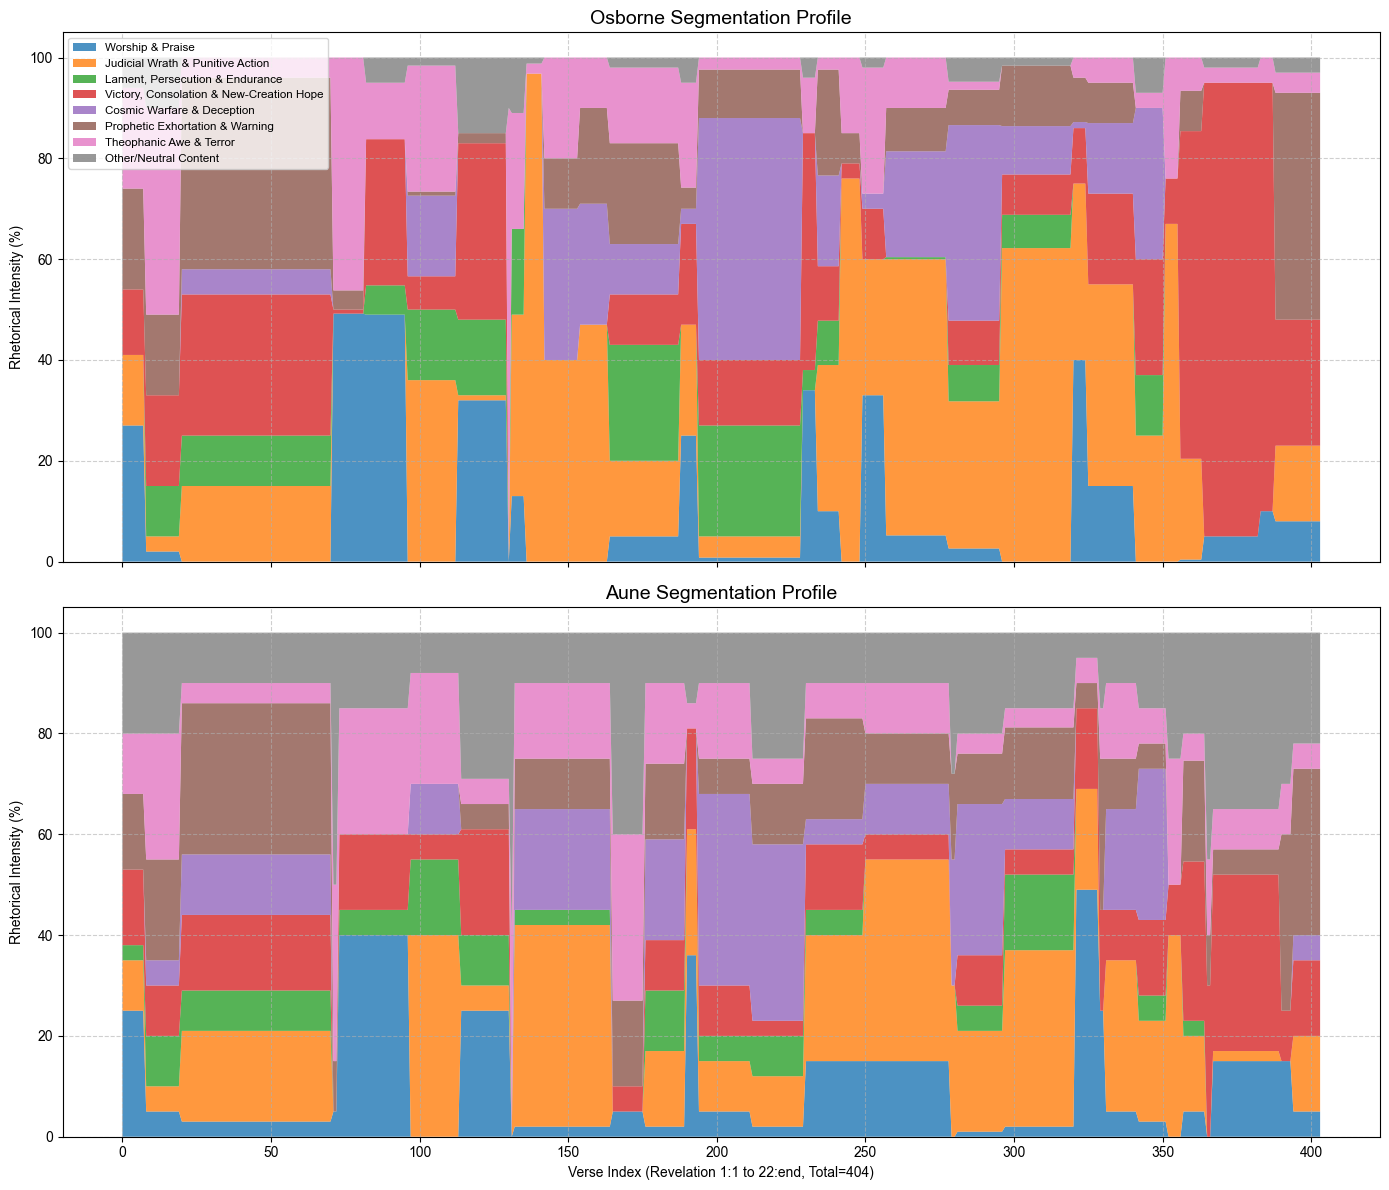


✅ Figure A2: Robustness Delta Heatmap (Osborne % - Aune %) saved to '../figures\robustness_delta_heatmap.jpg'


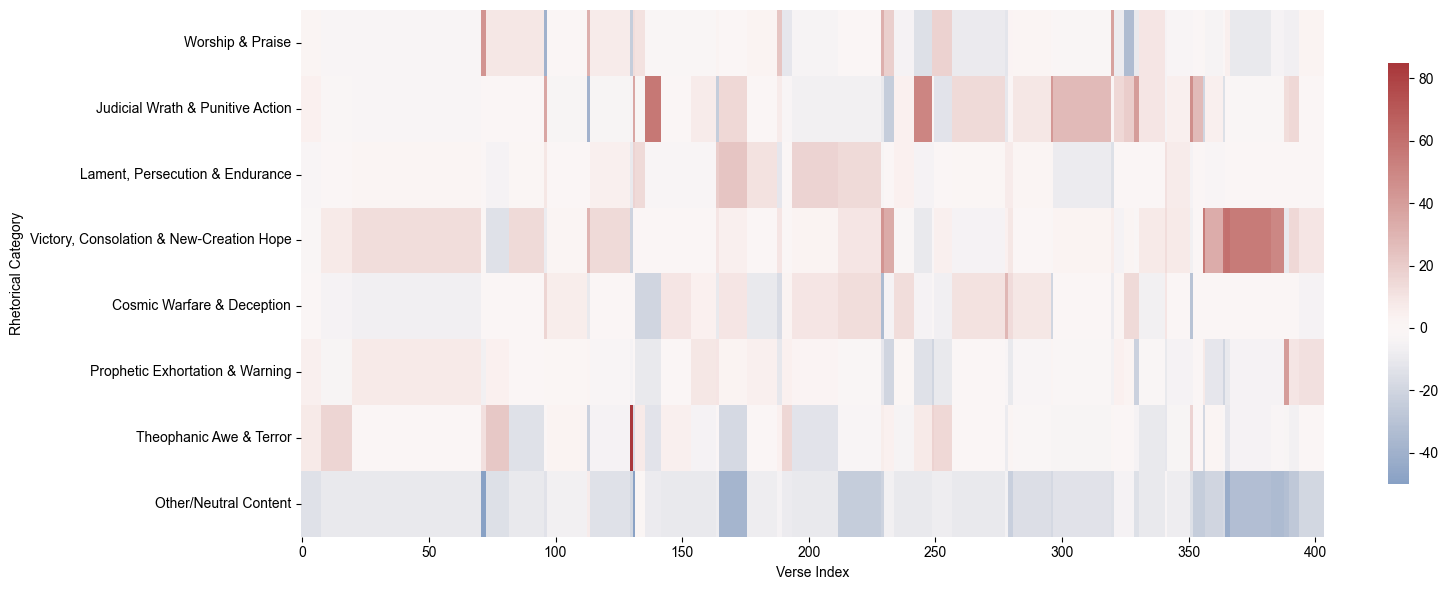


   APPENDIX A: ROBUSTNESS CHECK RESULTS

--- A.3: Headline Quantitative Results ---


,Vector,Pearson r,Spearman ρ,Mean Abs Δ (pp)
0,Worship & Praise,0.785560,0.679354,5.953465
1,Judicial Wrath & Punitive Action,0.786249,0.837227,9.264356
2,"Lament, Persecution & Endurance",0.469132,0.579682,4.659406
3,"Victory, Consolation & New-Creation Hope",0.862036,0.780127,10.469307
4,Cosmic Warfare & Deception,0.841406,0.738313,6.256436
5,Prophetic Exhortation & Warning,0.860544,0.769499,5.202475
6,Theophanic Awe & Terror,0.629975,0.678541,6.035644
7,Other/Neutral Content,0.326514,0.453555,14.271782



--- A.6: Key-Peak Concordance Table ---


,Theme,Peak Verses (Osborne ID),Peak Verses (Aune ID),Concordant?
0,Wrath,RE 8:7-12 (unit_010),RE 6:1-17 (unit_006),✘
1,Deception,RE 12:1-13:18 (unit_015),RE 11:19-12:17 (unit_013),✔
2,Worship,RE 4:1-11 (unit_004),RE 19:1-8 (unit_020),✘
3,Consolation,RE 21:9-27 (unit_028),RE 21:10-22:5 (unit_027),✔
4,Lament,RE 10:1-11:13 (unit_013),RE 6:1-17 (unit_006),✘



--- Analysis Complete ---


In [10]:
# @title Appendix A, Osborne Structure vs. Aune Structure
# ╔═══════════════════════════════════════════════════════════╗
# ║ Notebook 02: Robustness Check (Osborne vs. Aune)          ║
# ╚═══════════════════════════════════════════════════════════╝
# This notebook executes the robustness check detailed in Appendix A.
# It compares the rhetorical profiles generated using Grant R. Osborne's
# segmentation against David E. Aune's segmentation of the same Greek text.

# --- 1️⃣  Setup and Imports ---
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys
from collections import OrderedDict
from IPython.display import display

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Calibri']
mpl.rcParams['axes.unicode_minus'] = False

# Ensure helper functions are available
# Assumes this notebook is in /notebooks/ and src is in the root directory.
sys.path.append('../')
from src.corpus_parser import load_json, get_verse_map, parse_citation_to_indices, VERSES_PER_CHAPTER_GREEK
from src.analysis_utils import interpolate_to_verses
from src.config import *
CATEGORIES = ANALYTICAL_CONCEPTS_LIST

# --- 2️⃣  Configuration ---
# Input files (must be generated by the corrected 01 notebook)
OSBORNE_STRUCTURE_FILE = os.path.join(PATH_PROCESSED, 'osborne_greek_structured.json')
OSBORNE_RESULTS_FILE = os.path.join(PATH_RESULTS, 'gemini_osborne_greek.json')
AUNE_STRUCTURE_FILE = os.path.join(PATH_PROCESSED, 'aune_greek_structured.json')
AUNE_RESULTS_FILE = os.path.join(PATH_RESULTS, 'gemini_aune_greek.json')

# Output files as per Appendix C
ROBUSTNESS_METRICS_FILE = os.path.join(PATH_RESULTS, 'robustness_metrics.json')
PEAK_CONCORDANCE_FILE = os.path.join(PATH_RESULTS, 'peak_concordance.json')
STREAMGRAPH_COMP_FILE = os.path.join(PATH_FIGURES, 'streamgraph_comparison.jpg')
DELTA_HEATMAP_FILE = os.path.join(PATH_FIGURES, 'robustness_delta_heatmap.jpg')

# Function to sanitize text for display
def sanitize_text_data(df):
    """Remove or replace problematic characters in DataFrame labels"""
    def clean_text(text):
        if isinstance(text, str):
            return text.replace('\uFFFD', '?')
        return text
    
    # Clean column labels
    if hasattr(df, 'columns'):
        df.columns = [clean_text(x) for x in df.columns]
    return df

# --- 3️⃣  Data Loading and Preparation ---
def load_and_prepare_data(structure_file, results_file):
    """Loads segmentation and rhetorical scores, returning structured dataframes."""
    structured_data = load_json(structure_file)['narrative_units']
    seg_df = pd.DataFrame(structured_data)

    results_data = load_json(results_file)['narrative_units']
    scores_list = []
    for unit in results_data:
        scores_list.append({
            'unit_id': unit['unit_id'],
            'mu': [unit['final_rhetorical_vector'].get(cat, 0.0) for cat in CATEGORIES]
        })
    score_df = pd.DataFrame(scores_list)
    return seg_df, score_df

# --- 4️⃣  Main Analysis Pipeline ---
def run_robustness_analysis():
    """Executes the full robustness check as per Appendix A."""
    print("--- Starting Robustness Analysis (Appendix A) ---")
    os.makedirs(PATH_FIGURES, exist_ok=True)

    # A.2 (Segmentation & Aggregation): Load data
    osborne_seg, osborne_scores = load_and_prepare_data(OSBORNE_STRUCTURE_FILE, OSBORNE_RESULTS_FILE)
    aune_seg, aune_scores = load_and_prepare_data(AUNE_STRUCTURE_FILE, AUNE_RESULTS_FILE)
    print("✅ Data loaded for Osborne and Aune segmentations.")

    # Dynamically calculate TOTAL_VERSES from the source text segmentation
    TOTAL_VERSES = osborne_seg['num_verses'].sum()
    print(f"✅ Dynamically determined total verses: {TOTAL_VERSES}")

    # Interpolate scores to a per-verse grid for direct comparison
    osborne_verse_scores = interpolate_to_verses(osborne_seg, osborne_scores, TOTAL_VERSES, len(CATEGORIES))
    aune_verse_scores = interpolate_to_verses(aune_seg, aune_scores, TOTAL_VERSES, len(CATEGORIES))
    print("✅ Scores interpolated to per-verse grid.")

    # A.2 (Comparison Metrics): Calculate Pearson's r, Spearman's ρ, and Mean Absolute Delta
    metrics = []
    for i, cat in enumerate(CATEGORIES):
        r, _ = pearsonr(osborne_verse_scores[:, i], aune_verse_scores[:, i])
        rho, _ = spearmanr(osborne_verse_scores[:, i], aune_verse_scores[:, i])
        delta = np.mean(np.abs(osborne_verse_scores[:, i] - aune_verse_scores[:, i]))
        metrics.append(OrderedDict([("Vector", cat), ("Pearson r", r), ("Spearman ρ", rho), ("Mean Abs Δ (pp)", delta)]))

    df_metrics = pd.DataFrame(metrics)
    df_metrics = sanitize_text_data(df_metrics)  # Sanitize before display
    df_metrics.to_json(ROBUSTNESS_METRICS_FILE, orient='records', indent=4)
    print(f"✅ Comparison metrics calculated and saved to '{ROBUSTNESS_METRICS_FILE}'")

    # A.6 (Key-Peak Concordance): Find and compare peaks for key themes using robust intersection logic
    verse_map = get_verse_map(tuple(VERSES_PER_CHAPTER_GREEK.items()))
    theme_map = {'Wrath': 1, 'Deception': 4, 'Worship': 0, 'Consolation': 3, 'Lament': 2}
    peak_data = []
    for theme, cat_idx in theme_map.items():
        os_peak_idx = osborne_scores['mu'].apply(lambda x: x[cat_idx]).idxmax()
        au_peak_idx = aune_scores['mu'].apply(lambda x: x[cat_idx]).idxmax()
        os_unit = osborne_seg.iloc[os_peak_idx]
        au_unit = aune_seg.iloc[au_peak_idx]

        # Convert ranges to sets of global verse indices
        os_indices = parse_citation_to_indices(os_unit['range'], verse_map, VERSES_PER_CHAPTER_GREEK)
        au_indices = parse_citation_to_indices(au_unit['range'], verse_map, VERSES_PER_CHAPTER_GREEK)

        # Check for non-empty intersection
        concordant = '✔' if os_indices.intersection(au_indices) else '✘'

        peak_data.append(OrderedDict([
            ("Theme", theme),
            ("Peak Verses (Osborne ID)", f"{os_unit['range']} ({os_unit['unit_id']})"),
            ("Peak Verses (Aune ID)", f"{au_unit['range']} ({au_unit['unit_id']})"),
            ("Concordant?", concordant)
        ]))
    df_peaks = pd.DataFrame(peak_data)
    df_peaks = sanitize_text_data(df_peaks)  # Sanitize before display
    df_peaks.to_json(PEAK_CONCORDANCE_FILE, orient='records', indent=4)
    print(f"✅ Peak concordance table generated and saved to '{PEAK_CONCORDANCE_FILE}'")

    # A.4 (Visual Comparison): Generate figures
    # Side-by-side Streamgraphs (Figure A1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    ax1.stackplot(range(TOTAL_VERSES), osborne_verse_scores.T, labels=CATEGORIES, alpha=0.8)
    ax1.set_title("Osborne Segmentation Profile", fontsize=14)  # Added title without figure number
    ax1.set_ylabel("Rhetorical Intensity (%)")
    ax1.legend(loc='upper left', fontsize='small')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2.stackplot(range(TOTAL_VERSES), aune_verse_scores.T, labels=CATEGORIES, alpha=0.8)
    ax2.set_title("Aune Segmentation Profile", fontsize=14)  # Added title without figure number
    ax2.set_xlabel(f"Verse Index (Revelation 1:1 to 22:end, Total={TOTAL_VERSES})")
    ax2.set_ylabel("Rhetorical Intensity (%)")
    ax2.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(STREAMGRAPH_COMP_FILE, dpi=300)
    print(f"\n✅ Figure A1.1 & A1.2: Streamgraph comparison (Osborne vs. Aune segmentation) saved to '{STREAMGRAPH_COMP_FILE}'")
    plt.show()  # Display the figure
    
    # Difference Heatmap (Figure A2) - FIXED to prevent label cutoff
    diff = osborne_verse_scores - aune_verse_scores  # Calculate the difference matrix
    
    # Create figure with adjusted size and padding
    plt.figure(figsize=(16, 6))  # Wider figure to accommodate labels
    
    # Adjust subplot margins to make room for labels
    plt.subplots_adjust(left=0.15)  # Add more space on the left
    
    # Create the heatmap
    sns.heatmap(
        diff.T, 
        cmap='vlag', 
        center=0, 
        yticklabels=CATEGORIES, 
        xticklabels=50,
        cbar_kws={'shrink': 0.8}  # Make colorbar slightly smaller
    )
    
    plt.xlabel("Verse Index")
    plt.ylabel("Rhetorical Category")
    
    # Save with tight layout after heatmap is created
    plt.tight_layout()
    plt.savefig(DELTA_HEATMAP_FILE, dpi=300, bbox_inches='tight')
    print(f"\n✅ Figure A2: Robustness Delta Heatmap (Osborne % - Aune %) saved to '{DELTA_HEATMAP_FILE}'")
    plt.show()  # Display the figure

    # --- 5️⃣  Display Results in Notebook ---
    print("\n" + "="*50)
    print("   APPENDIX A: ROBUSTNESS CHECK RESULTS")
    print("="*50)
    print("\n--- A.3: Headline Quantitative Results ---")
    display(df_metrics)
    print("\n--- A.6: Key-Peak Concordance Table ---")
    display(df_peaks)
    print("\n--- Analysis Complete ---")

# --- Execution ---
if __name__ == '__main__':
    run_robustness_analysis()